# Setup and Helper Functions

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import ipywidgets as widgets

from matplotlib import pyplot as plt

sns.set_style(style="darkgrid")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
def multiplot_from_generator(g, num_columns):
    next(g)
    
    figsize = (15, 15/num_columns)
    
    try:
        while True:
            plt.figure(figsize=figsize)
            for col in range(num_columns):
                ax = plt.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

In [4]:
import geopy.distance
moscow_center = [55.751244, 37.618423]

def construct_features(data):
    
    # replacing longitude and latitude with distance in km
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data['distance'] = dist
    
    data['top_floor'] = data['floor'] == data['stories']
    data['top_floor'] = data['top_floor'].astype(int)
    data['age'] = 2021 - data['constructed']
    data["bathrooms"] = data.bathrooms_shared + data.bathrooms_private
    for ind, row in data.iterrows():
        data.at[ind, "elevator"] = row.elevator_passenger == 1 or row.elevator_service == 1
    data['elevator'] = data['elevator'].astype(int)
    for ind, row in data.iterrows():
        data.at[ind, "has_seller"] = pd.isna(row.seller)
    data['has_seller'] = data['has_seller'].astype(int)
    compute_distance_to_metro(data)
    
    return data

In [5]:
def compute_bearing(c1, c2):
    y = np.sin(c2[1] - c1[1]) * np.cos(c2[0])
    x = np.cos(c1[0]) * np.sin(c2[0]) - np.sin(c1[0]) * np.cos(c2[0]) * np.cos(c2[1] - c1[1])
    rad = np.arctan2(y, x)
    bearing = ((rad * 180 / np.pi) + 360) % 360
    return bearing

In [6]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

In [7]:
def compute_directional_data(data):
    for ind, row in data.iterrows():
        bearing = compute_bearing(moscow_center, [row["latitude"], row["longitude"]])
        data.at[ind, "bearing"] = bearing
        # if 0 <= bearing <= 22.5 or 337.5 < bearing <= 360:
        #     direction = 0 # N
        # elif 22.5 < bearing <= 67.5:
        #     direction = 1 # NE
        # elif 67.5 < bearing <= 112.5:
        #     direction = 2 # E
        # elif 112.5 < bearing <= 157.5:
        #     direction = 3 # SE
        # elif 157.5 < bearing <= 202.5:
        #     direction = 4 # S
        # elif 202.5 < bearing <= 247.5:
        #     direction = 5 # SW
        # elif 247.5 < bearing <= 292.5:
        #     direction = 6 # W
        # else:
        #     direction = 7 # NW
        # data.at[ind, "direction"] = direction
    return data

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    return ax

In [9]:
def one_hot_encode(data, categories, orig_var, remove_org=False):
    for k, category in categories.items():
        data[category] = (data[orig_var] == k).astype(int)
    if remove_org:
        data.drop(orig_var, axis=1, inplace=True)
    return data

In [10]:
def log_transform(data, features):
    for feature in features:
        data["log_{}".format(feature)] = np.log1p(data[feature])
    return data

In [11]:
import math
import re
import decimal
from sklearn.neighbors import KDTree
pd.set_option('display.max_rows', 275)

metro_data = pd.read_csv("data/metro_data.csv")
metro_data.at[0, "Coordinates"] = "55°48′53″N 37°44′03″E﻿ / ﻿55.8148°N 37.7342°E"
metro_data[["c1", "c2"]] = metro_data["Coordinates"].str.split("/", expand=True)
metro_data["c2"] = metro_data["c2"].str.strip()
metro_data[["latitude", "longitude", "rest"]] = metro_data["c2"].str.split(" ", expand=True)
metro_data["latitude"] = metro_data["latitude"].str.replace("°N", "")
metro_data["longitude"] = metro_data["longitude"].str.replace("°E", "")
metro_data["longitude"] = metro_data["longitude"].str.replace("disambiguation", "")
metro_data["latitude"] = metro_data["latitude"].str.replace("\ufeff", "")
metro_data["longitude"] = metro_data["longitude"].str.replace("\ufeff", "")
metro_data["latitude"] = metro_data["latitude"].astype(float)
metro_data["longitude"] = metro_data["longitude"].astype(float)
metro_coordinates = metro_data[["latitude", "longitude"]]

airport_coordinates = [[55.5822, 37.2453], [55.2431, 37.5422], [55.3546, 37.1603], [55.3312, 38.96], [55.3042, 37.3026]]
airport_coordinates = pd.DataFrame(airport_coordinates, columns=["latitude", "longitude"])


def compute_distance_to_metro(data):
    coordinate_tree = KDTree(metro_coordinates)
    airport_coordinate_tree = KDTree(airport_coordinates)
    for ind, row in data.iterrows():
        apartment_coordinates = [[row["latitude"], row["longitude"]]]
        min_distance = math.inf
        metro_coordinate_ind = coordinate_tree.query(apartment_coordinates, 1, return_distance=False)[0][0]
        metro_coordinate = metro_coordinates.loc[[metro_coordinate_ind]].to_numpy()
        min_distance = geopy.distance.distance(apartment_coordinates, metro_coordinate).km
        data.at[ind, "distance_to_metro"] = min_distance
        if min_distance <= 0.5:
            data.at[ind, "metro_distance_low"] = 1
            data.at[ind, "metro_distance_medium"] = 0
            data.at[ind, "metro_distance_high"] = 0
        elif min_distance <= 0.75:
            data.at[ind, "metro_distance_low"] = 0
            data.at[ind, "metro_distance_medium"] = 1
            data.at[ind, "metro_distance_high"] = 0
        else:
            data.at[ind, "metro_distance_low"] = 0
            data.at[ind, "metro_distance_medium"] = 0
            data.at[ind, "metro_distance_high"] = 1
        airport_coordinate_ind = airport_coordinate_tree.query(apartment_coordinates, 1, return_distance=False)[0][0]
        airport_coordinate = airport_coordinates.loc[[airport_coordinate_ind]].to_numpy()
        min_distance = geopy.distance.distance(apartment_coordinates, airport_coordinate).km
        data.at[ind, "distance_to_airport"] = min_distance
            

# Load Data

In [12]:
apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

# load meta info
with open('data/apartments_meta.json') as f:
    apartments_meta = json.load(f)
    
with open('data/buildings_meta.json') as f:
    buildings_meta = json.load(f)

meta_info = apartments_meta + buildings_meta

Merge building and apartment data

In [13]:
train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

In [14]:
train.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,Саларьево Парк ЖК,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,улица Сервантеса,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [15]:
test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


### Missing longitude and latitude in test data
Replace the missing longitude and latitude in the testdata with the coordinates retrieved from Google Maps based on the address.

In [16]:
ind = test[test["longitude"].isna()].index
test.at[ind, "latitude"] = 55.56776345324702
test.at[ind, "longitude"] = 37.48171529826662

# Exploratory Data Analysis

## Meta Information

In [17]:
import json

def print_meta_info():
    
    df_data = []
    for entry in meta_info:
        nan_count_train, nan_count_test = np.NaN, np.NaN
        data_type = entry["name"]
        if data_type in train:
            nan_count_train = len(train[train[data_type].isna()])
        if data_type in test:
            nan_count_test = len(test[test[data_type].isna()])
        row = [entry["name"], entry["type"], entry["desc"], nan_count_train, nan_count_test]
        df_data.append(row)
    
    df = pd.DataFrame(df_data, columns=["name", "type", "desc", "nan_count_train", "nan_count_test"])
    return df

meta_df = print_meta_info()
meta_df

,name,type,desc,nan_count_train,nan_count_test
0,id,integer_id,Unique ID for apartment,0,0.0
1,seller,categorical,The type of apartment seller,8830,3942.0
2,price,real,The listed price of the apartment (TARGET),0,NaN
3,area_total,real,Total area of the apartment,0,0.0
4,area_kitchen,real,Total kitchen area in the apartment,4721,2233.0
5,area_living,real,Total living space area in the apartment,3882,2019.0
6,floor,integer,Primary building floor of the apartment,0,0.0
7,rooms,integer,Number of rooms in the apartment,0,0.0
8,layout,categorical,Overal apartment layout,17642,7368.0
9,ceiling,real,Ceiling height in the apartment,11093,5018.0


<AxesSubplot:title={'center':'Fraction of NaN values in the test set'}>

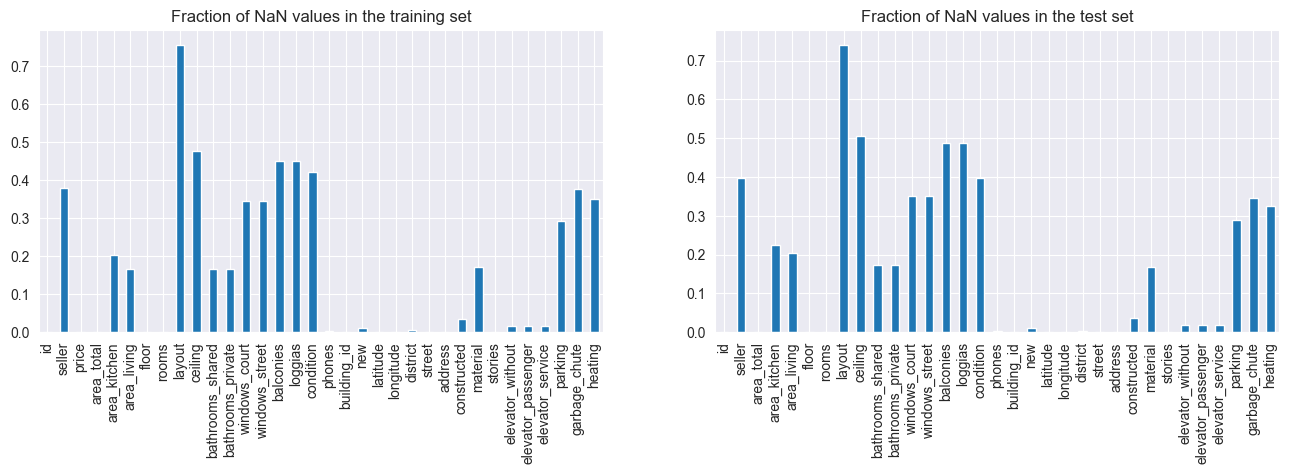

In [18]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the test set')

**EDA insight:** Several features in both the training and test contain multiple NaN values. The distribution of NaN values appears to be similar in both datasets. However, the test data also has two rows with missing longitude and latitude values.

## Statistics

In [19]:
print("Number of training samples: {}".format(train.shape[0]))
print("Number of test samples: {}".format(test.shape[0]))
print("Number of features: {}".format(train.shape[1]))

Number of training samples: 23285
Number of test samples: 9937
Number of features: 34


In [20]:
print("Train data statistics")
train.describe()

Train data statistics


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,23285.000000,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,19413.000000,15213.000000,15213.000000,12765.000000,12765.000000,13475.000000,23205.000000,23285.000000,23021.000000,23285.000000,23285.000000,23155.000000,22491.000000,19313.000000,23285.000000,22928.000000,22928.000000,22928.000000,16497.000000,14474.000000,15124.000000
mean,11642.000000,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,0.662855,0.797147,0.468678,0.556365,0.673090,1.270501,1.162293,4844.089156,0.337692,55.728337,37.583425,4.654848,2002.729581,2.203956,17.608933,0.392620,0.929867,0.743109,0.572589,0.806411,0.176012
std,6721.944845,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,0.716888,0.402137,0.499034,0.641257,0.664779,1.017037,0.456937,2790.676698,0.472933,0.101831,0.150181,3.155835,22.948365,1.021101,11.216638,0.488344,0.255376,0.436928,0.549630,0.395124,0.566275
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.211430,36.864371,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5821.000000,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2426.000000,0.000000,55.664837,37.497827,2.000000,1989.000000,2.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,11642.000000,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4772.000000,0.000000,55.738622,37.571938,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,17463.000000,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7340.000000,1.000000,55.797458,37.671085,7.000000,2020.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9735.000000,1.000000,56.006507,37.950668,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


**EDA insight:** There is a significant difference between the 75% percentile and the maximum value for the price, area_total, area_kitchen, area_living, floor, rooms, ceiling, loggias, balconies, and stories features, suggesting the presence of outliers. These need to be handled.

In [21]:
print("Test data statistics")
test.describe()

Test data statistics


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,9937.000000,5995.000000,9937.000000,7704.000000,7918.000000,9937.000000,9937.000000,2569.000000,4919.000000,8220.000000,8220.000000,6449.000000,6449.000000,5102.000000,5102.000000,5978.000000,9897.000000,9937.000000,9828.000000,9937.000000,9937.000000,9912.000000,9563.000000,8266.000000,9937.000000,9757.000000,9757.000000,9757.000000,7070.000000,6511.000000,6707.000000
mean,28253.000000,1.805838,75.144219,12.874883,39.500515,9.184160,2.202878,1.036201,3.725885,0.776642,0.611922,0.809273,0.438518,0.584673,0.632301,1.259284,1.175003,4694.767032,0.302503,55.710949,37.562863,4.656275,2002.239569,2.236632,18.107578,0.428513,0.924567,0.746438,0.556577,0.764552,0.140152
std,2868.709146,1.087742,56.359318,6.878015,33.145228,7.963073,1.107315,0.334674,15.915162,0.811608,0.709386,0.392905,0.496244,0.645422,0.669174,1.041879,0.462727,2772.449218,0.459365,0.810306,2.441198,3.156144,23.635988,1.063680,10.725279,0.494889,0.264102,0.435072,0.578640,0.424311,0.515819
min,23285.000000,0.000000,13.000000,1.200000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,17.141734,-61.790500,0.000000,1860.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25769.000000,1.000000,42.400000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,0.000000,55.669772,37.492455,2.000000,1988.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,28253.000000,2.000000,59.600000,10.800000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4728.000000,0.000000,55.738449,37.568920,5.000000,2014.000000,2.000000,17.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,30737.000000,3.000000,86.000000,16.000000,45.400000,13.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,6983.000000,1.000000,55.798905,37.662812,7.000000,2019.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,33221.000000,3.000000,1175.000000,63.600000,528.000000,69.000000,6.000000,2.000000,350.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9734.000000,1.000000,56.001625,132.768097,11.000000,2022.000000,6.000000,87.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [22]:
train = construct_features(train)
test = construct_features(test)

**EDA insight:** There are some latitude and longitude values in the test data indicating a location far away from moscow.

In [23]:
features = train.columns[train.columns != "price"]
def plot_price_feature_relation():
    for feature in features:
        yield
        sns.scatterplot(x=feature, y="price", data=train)

# multiplot_from_generator(plot_price_feature_relation(), 3)

**EDA insight**:
1. area_total has a high correlation with the price. It would be interesting to see if the correlation increases if only houses that are close to the city center (i.e. not further than 10kms) are considered. The same applies to area_living.
2. It would be interesting to see if there are some streets where the house prices tend to be higher than in other streets (similar to monopoly).
3. For houses built after 1990, the house prices tend to increase with a lower age, whereas it is the opposite for houses built before 1990. If the house was built before 1990, the older it is, the more expensive it gets.
4. The distance certainly appears to play a role. If the houses are further away than 15kms from the city center, the prices tend to be very low. However, the variance is quite high for the houses even if they are close to the image center. The reason for this needs to be investigated. It may be due to the age of the building.
5. It would be interesting to see how the age and distance behave with respect to the price. For instance, do houses with a low distance but high age tend to be cheaper?
6. Could there be a relation between the age and the number of stories as well as the price? For example, do new buildings tend to have more floors than old buildings and if so, does this have a positive correlation with the price?
7. There is a high variability between the prices in some districts? What may be the cause of this? Can it be related to the age?
8. Do buildings that are close to each other have similar prices? E.g., if there the neighbouring building tends to be expensive, is the other building also expensive?

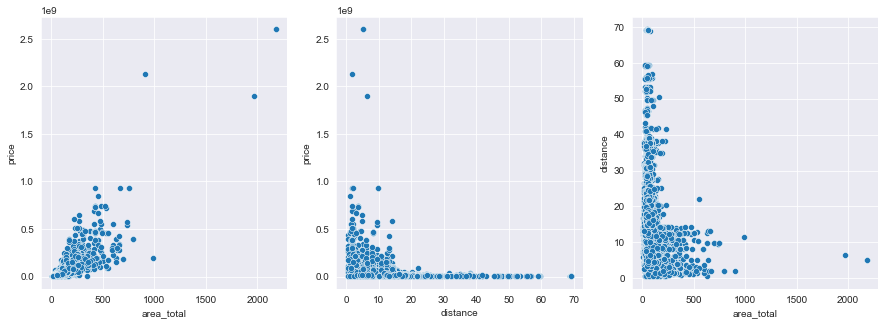

In [24]:
plt.show()
def area_total_distance_price():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price", data=d)
    yield
    sns.scatterplot(x="distance", y="price", data=d)
    yield
    sns.scatterplot(x="area_total", y="distance", data=d)

multiplot_from_generator(area_total_distance_price(), num_columns=3)

**EDA insight**: Houses further away from the center have a rather low total area than those close to the center.
**EDA insight**: Considering the price per square meter could give further insight.

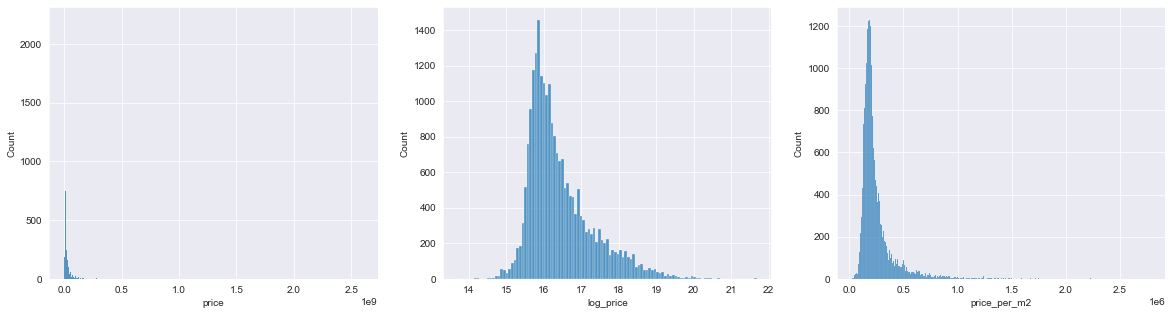

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=train["price"], ax=ax[0])
train["log_price"] = np.log1p(train["price"])
sns.histplot(data=train["log_price"], ax=ax[1])
train["price_per_m2"] = train["price"] / train["area_total"]
sns.histplot(data=train["price_per_m2"], ax=ax[2])
plt.show()

**EDA insight:** As we can see, the unadjusted price is significantly right skewed. While computing the price per square meter looks a bit better, a log transformation of the price is even better.

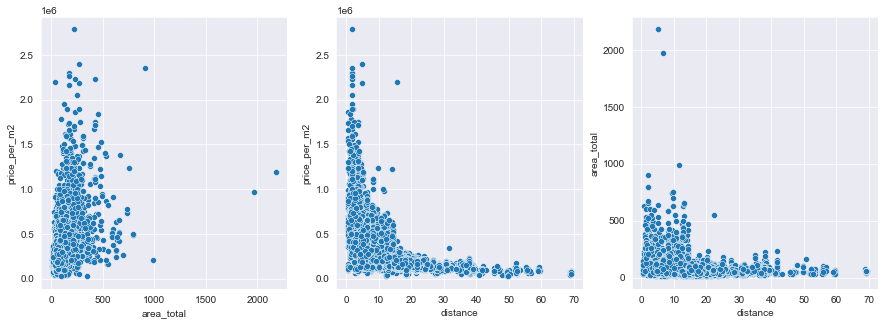

In [26]:
def area_total_distance_price_per_m2():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance", y="area_total", data=d)

multiplot_from_generator(area_total_distance_price_per_m2(), num_columns=3)

**EDA insight:** The m2 price increases significantly with a shorter distance and indicates a clearer relationship than the price alone. However, there is still a strong variability which needs to be further investigated. What distinguishes cheap houses that are close to the center from expensive ones? Age? Number of stories? The street they are placed in? The price of other houses in the vicinity?

Possible features of interest:
* Distance to schools, shopping and entertainment opportunities, as well as recreational centers
* Proximity to public transport and highways
* neighbourhood comps, i.e., clusterings of the homes

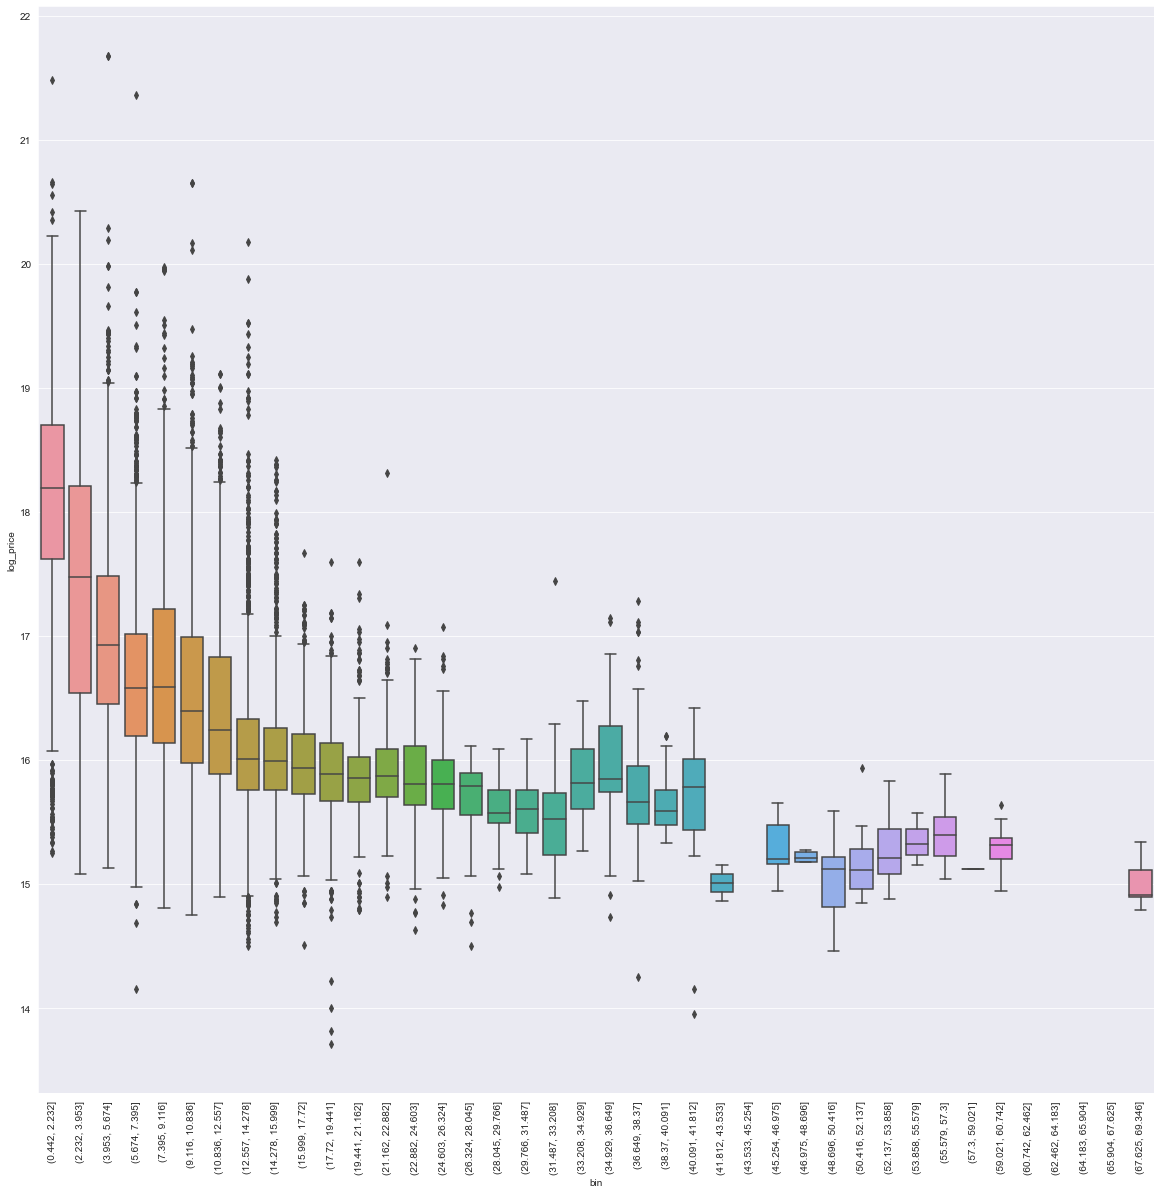

In [27]:
plt.figure(figsize=(20,20))
d = train
d["bin"], bins = pd.cut(d["distance"], bins=40, retbins=True)
ax = sns.boxplot(data=d, x="bin", y="log_price")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**EDA insight:** The boxplot illustrates that there is a negative correlation between the log_price and the distance. However, there are several outliers in the bins with apartments closer to the city.

In [28]:
train = compute_directional_data(train)
test = compute_directional_data(test)

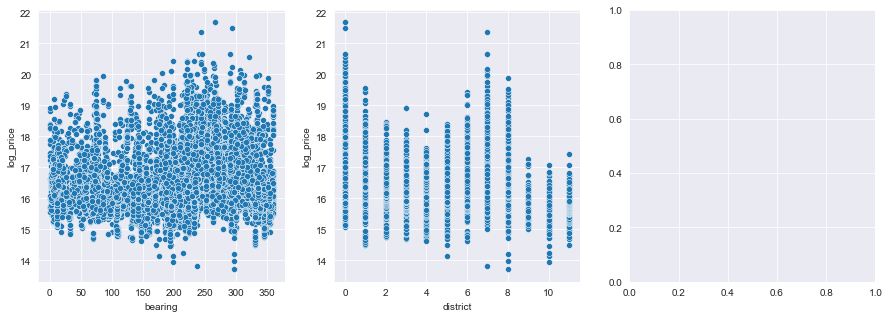

In [29]:
d = train
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x="bearing", y="log_price", data=d, ax=ax[0])
sns.scatterplot(x="district", y="log_price", data=d, ax=ax[1])
# sns.scatterplot(x="direction", y="log_price", data=d, ax=ax[2])
plt.show()

(<AxesSubplot:title={'center':'Moscow apartment log_price by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x131860c40>)

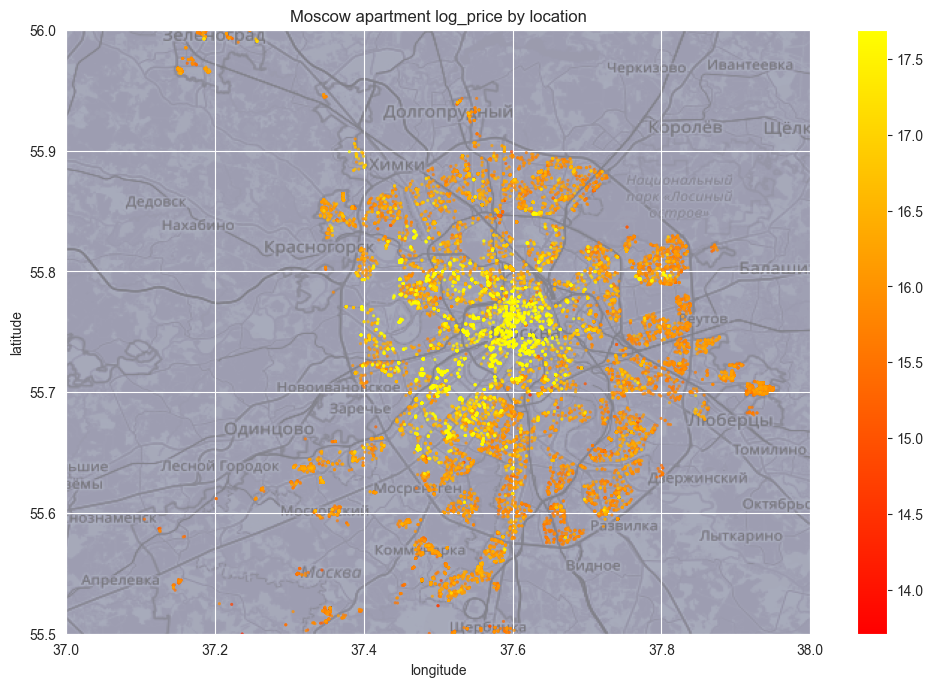

In [30]:
d = train
plot_map(data=d, column="log_price", title="Moscow apartment log_price by location")

**EDA insight:** Apartments that are in the center (0), west (7) and north-west (8) district have a greater log price variation than other districts. This difference can also be observed in the bearing (210 - 310) and direction (W - 6, NW - 7) plots and on the map plot.

0.6511642203709398


<AxesSubplot:xlabel='bathrooms', ylabel='log_price'>

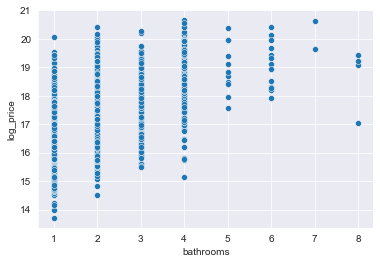

In [31]:
train["bathrooms"] = train.bathrooms_shared + train.bathrooms_private
d = train
print(d["bathrooms"].corr(d["log_price"]))
sns.scatterplot(x="bathrooms", y="log_price", data=d)

**EDA insight:** Number of bathrooms (shared or private) seem to have a positive effect on the log price.

Correlation area_total: 0.7825645168629933 | Correlation log_area_total: 0.8754840271438106


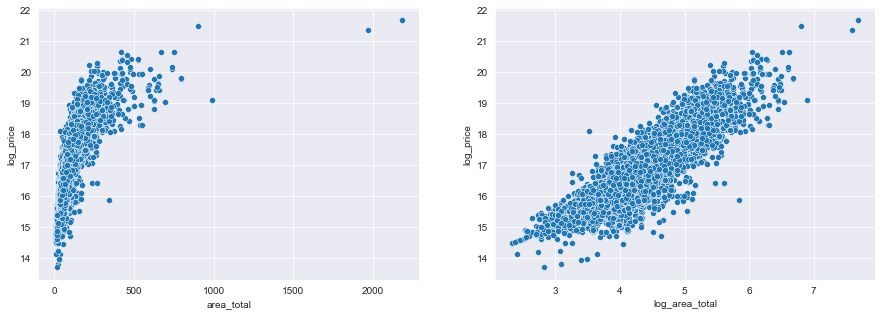

In [32]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_total", y="log_price", data=d, ax=ax[0])
d["log_area_total"] = np.log1p(d["area_total"])
sns.scatterplot(x="log_area_total", y="log_price", data=d, ax=ax[1])
print("Correlation area_total: {} | Correlation log_area_total: {}".format(d["area_total"].corr(d["log_price"]), d["log_area_total"].corr(d["log_price"])))

Correlation area_living: 0.7496293729728276 | Correlation log_area_living: 0.7091494404484565


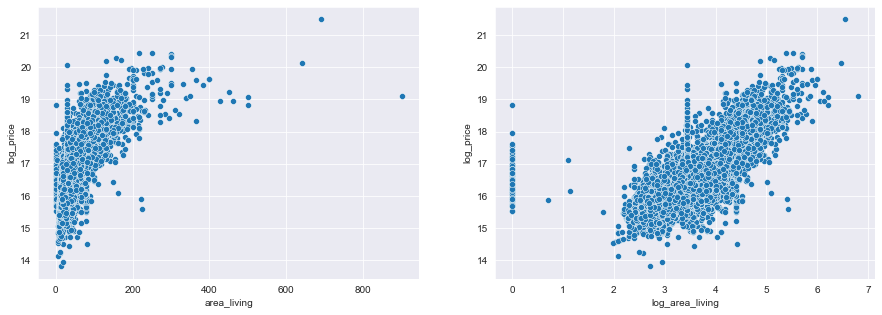

In [33]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_living", y="log_price", data=d, ax=ax[0])
d["log_area_living"] = np.log1p(d["area_living"])
sns.scatterplot(x="log_area_living", y="log_price", data=d, ax=ax[1])
print("Correlation area_living: {} | Correlation log_area_living: {}".format(d["area_living"].corr(d["log_price"]), d["log_area_living"].corr(d["log_price"])))

Correlation area_kitchen: 0.517460817836073 | Correlation log_area_kitchen: 0.521042228030699


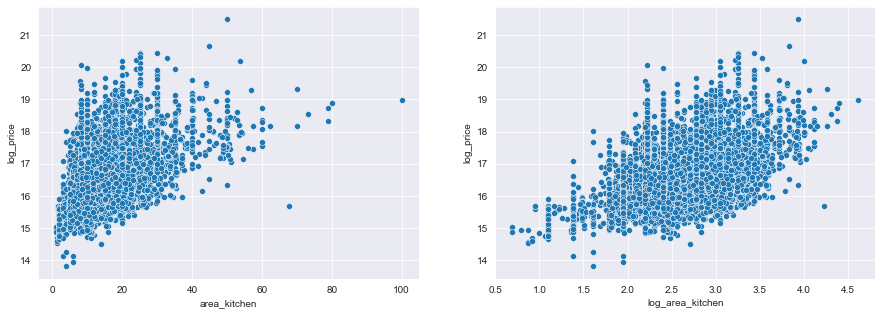

In [34]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_kitchen", y="log_price", data=d, ax=ax[0])
d["log_area_kitchen"] = np.log1p(d["area_kitchen"])
sns.scatterplot(x="log_area_kitchen", y="log_price", data=d, ax=ax[1])
print("Correlation area_kitchen: {} | Correlation log_area_kitchen: {}".format(d["area_kitchen"].corr(d["log_price"]), d["log_area_kitchen"].corr(d["log_price"])))

**EDA insight:** The log transformed area_total has a significantly higher correlation than the area_total parameter.

Correlation distance: -0.5344713194808199 | Correlation log_distance: -0.613751320604497


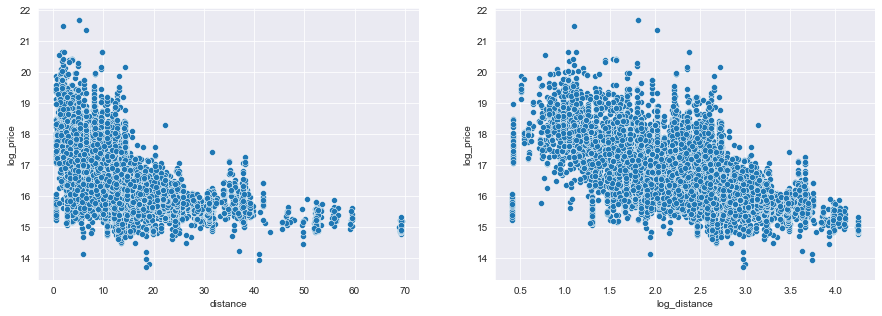

In [35]:
d = train.copy()
d["log_distance"] = np.log1p(d["distance"])
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="distance", y="log_price", data=d, ax=ax[0])
sns.scatterplot(x="log_distance", y="log_price", data=d, ax=ax[1])
print("Correlation distance: {} | Correlation log_distance: {}".format(d["distance"].corr(d["log_price"]), d["log_distance"].corr(d["log_price"])))

**EDA insight:** Performing a log transformation on the distance slightly increased the correlation with the log price since the distance was slightly skewed.

In [36]:
print("Skewness in training data:")
skew_feats = train.skew().sort_values(ascending=False)
pd.DataFrame({'Skew': skew_feats}).T

Skewness in training data:


/var/folders/qj/3xgy61cn4896krzkbpyn7gth0000gn/T/ipykernel_22257/2914573080.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew_feats = train.skew().sort_values(ascending=False)


,ceiling,price,area_total,distance_to_metro,area_living,price_per_m2,heating,top_floor,floor,stories,area_kitchen,bathrooms,distance,metro_distance_low,metro_distance_medium,age,log_price,bathrooms_shared,bathrooms_private,balconies,loggias,rooms,new,phones,layout,has_seller,elevator_without,distance_to_airport,district,condition,parking,windows_street,building_id,id,seller,longitude,bearing,metro_distance_high,latitude,material,elevator_service,constructed,windows_court,garbage_chute,elevator,elevator_passenger
Skew,26.90155,19.152175,8.610355,6.561202,5.319536,3.95057,3.824381,3.292655,2.790601,2.27116,2.207571,2.023348,1.738205,1.55241,1.486407,1.476935,1.255021,0.990077,0.970663,0.934573,0.857511,0.804358,0.68645,0.590888,0.57412,0.497922,0.439809,0.374151,0.291343,0.285369,0.228894,0.125547,0.022041,0.0,-0.268167,-0.29218,-0.297066,-0.428793,-0.450969,-0.514593,-1.112906,-1.476935,-1.478035,-1.551179,-3.040358,-3.36684


**EDA insight:** Some features have a high skewness, such as ceiling, price, area_total, etc. Skewness may cause issues and should be handled, i.e., by applying a log transformation.

## Feature Relations

### Correlation

<AxesSubplot:>

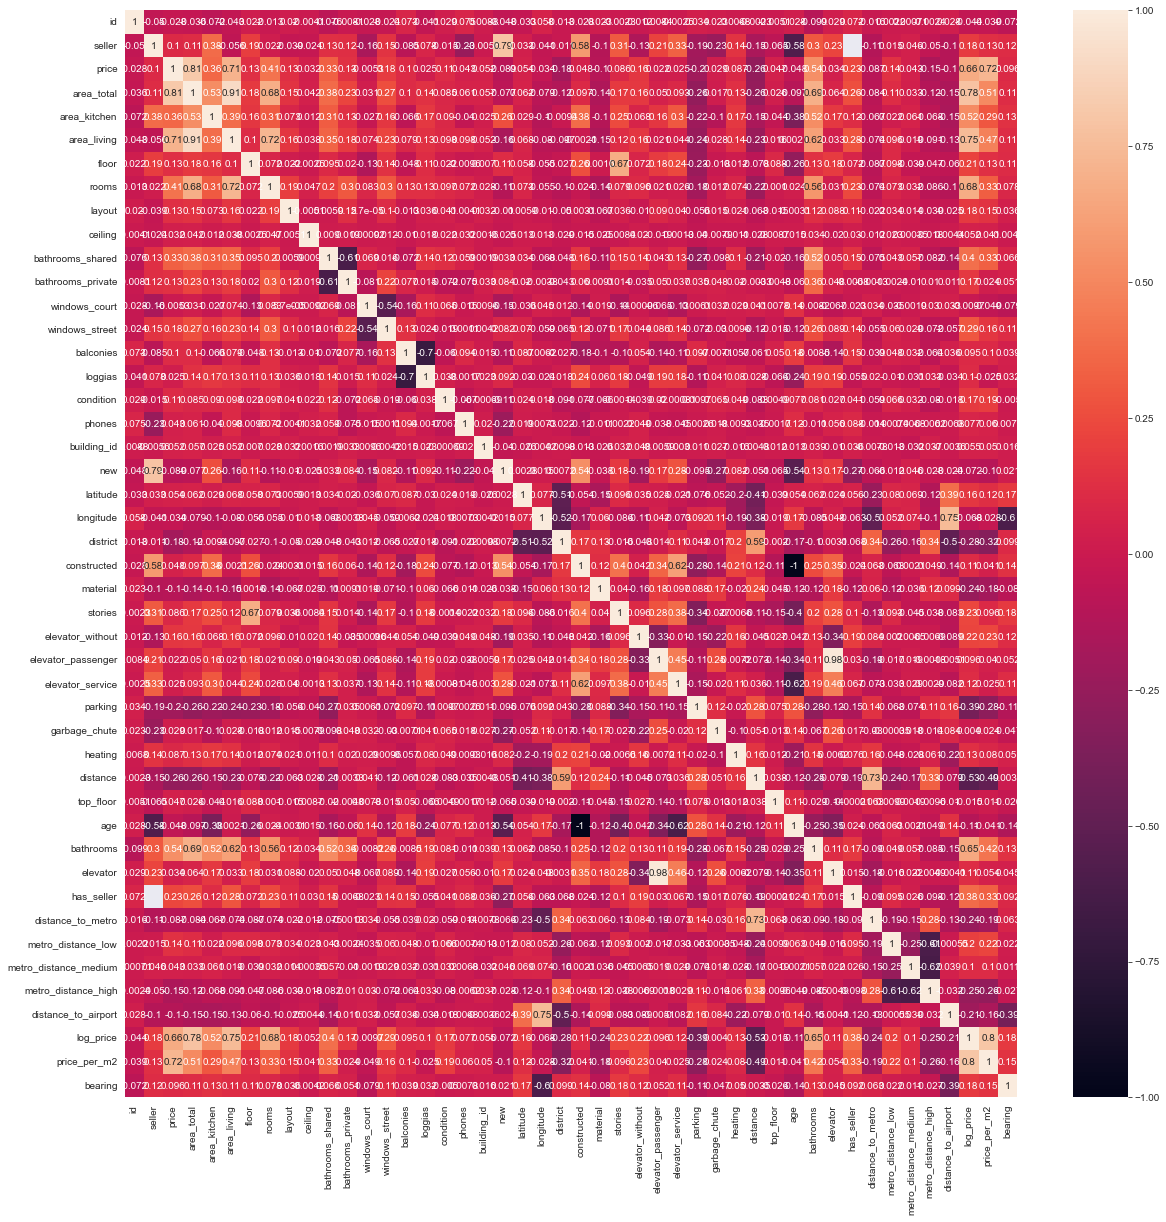

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True)

**EDA insight:** Correlation between the price and area_total, area_kitchen, area_living, floor, rooms, layout, bathrooms_shared, bathrooms_private, windows_street, balconies, district, material, elevator_without, and parking. However, some correlations may not be as strong as implied due the high number of missing values in some features, such as layout, balconies and condition.

In [38]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train[train[feature].isna()]) for feature in train.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
corr_df

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
layout,0.178670,17642,0.757655
ceiling,0.051916,11093,0.476401
loggias,0.104360,10520,0.451793
balconies,0.094621,10520,0.451793
condition,0.173769,9810,0.421301
seller,0.182874,8830,0.379214
garbage_chute,0.004026,8811,0.378398
heating,0.130949,8161,0.350483
windows_court,-0.009696,8072,0.346661
windows_street,0.289950,8072,0.346661


# Data Cleaning

##  Drop features with very high percentage of nans and low correlation

In [39]:
nan_threshold = 0.3
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() > 0.1)]
rel_feats.sort_values(by="corr", ascending=False)

,corr,nan_count,nan_percentage
log_price,1.000000,0,0.000000
price_per_m2,0.801305,0,0.000000
area_total,0.782565,0,0.000000
area_living,0.749629,3882,0.166717
rooms,0.678219,0,0.000000
price,0.664611,0,0.000000
bathrooms,0.651164,3872,0.166287
area_kitchen,0.517461,4721,0.202749
bathrooms_shared,0.396012,3872,0.166287
has_seller,0.375276,0,0.000000


## Impute Missing Values

In [40]:
def impute_with_bin_mean(data, feature, bin_feature, bins=40, decimals=0, verbose=False): 
    tr = train.copy()
    te = test.copy()
    database = pd.concat([tr, te])
    database["bin"], bins = pd.cut(database[bin_feature], bins=40, retbins=True)
    pb = 0
    for b in bins:
        bin_data = database[(database[bin_feature] >= pb) & (database[bin_feature] <= b)]
        bin_mean = bin_data[feature].mean()
        percentage = (bin_mean / bin_data[bin_feature]).mean()
        d = data[(data[bin_feature] >= pb) & (data[bin_feature] <= b)]
        ind = d[d[feature].isna()].index
        if pd.notna(bin_mean) and len(ind) > 0:
            bin_mean = round(bin_mean, decimals)
            data.at[ind, feature] = bin_mean
            if verbose:
                print("Set {} for {} rows with {} <= area_living <= {} to {}".format(feature, len(ind), pb, b, bin_mean))
        pb = b

In [41]:
def impute_nearest_neighbour_mean(data, feature, k, decimals=0):
    tr = train.copy()
    te = test.copy()
    database = pd.concat([tr, te], ignore_index=True)
    kd_tree = KDTree(database[["latitude", "longitude"]])
    d = data[data[feature].isna()]
    for ind, row in d.iterrows():
        coordinates = [[row["latitude"], row["longitude"]]]
        neighbours = kd_tree.query(coordinates, k=k, return_distance=False)[0]
        neighbour_mean = database.loc[neighbours][feature].mean()
        if not pd.isna(neighbour_mean):
            data.at[ind, feature] = round(neighbour_mean, decimals)

### District
Apartments with missing district will be added to the district: other (12)

In [42]:
ind = train[train["district"].isna()].index
train.at[ind, "district"] = 12
ind = test[test["district"].isna()].index
test.at[ind, "district"] = 12

### Impute area_living, area_kitchen, bathrooms, and parking using the mean of apartments with similar sizes, i.e., area_total

For buildings with a similar total area, the total living area is presumably about the same. Hence, it would make sense to set the value of the living area to the mean across apartments with a similar total area. The same applies to area_kitchen.

In [43]:
def impute_area_living(data):
    feature = "area_living"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    d = data[data.area_living.isna()]
    for ind, row in d.iterrows():
        data.at[ind, feature] = 0.85 * row.area_total
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

def impute_area_kitchen(data):
    feature = "area_kitchen"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    d = data[data.area_kitchen.isna()]
    for ind, row in d.iterrows():
        data.at[ind, feature] = 0.05 * row.area_total
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

def impute_bathrooms(data):
    feature = "bathrooms"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    ind = data[data.area_total <= 800].index
    data.at[ind, feature] = 5
    ind = data[data.area_total > 800].index
    data.at[ind, feature] = 6
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

def impute_parking(data): 
    feature = "parking"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    ind = data[data.parking.isna()].index
    data.at[ind, feature] = 0
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

As we can see, some nan_values remain since no values existed in the corresponding bin. These need to be handled differently.

### elevator_without
It is assumed that elevators with a similar number of stories also have the same setting for elevator without.

In [44]:
def impute_elevator_without(data):
    feature = "elevator_without"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="stories", bins=20)
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

### constructed
It is assumed that the majority of the buildings in the same district have been constructed in the same area. A more accurate, approach would be to base the construction year of buildings with missing values on other buildings in the same street. However, since this is more computationally expensive, it has been disregarded.

In [45]:
def impute_constructed_and_age(data):
    d = data[data.constructed.isna()]
    ind = d[d.new == 1].index
    data.at[ind, "constructed"] = 2021
    data.at[ind, "age"] = 0
    # impute_with_bin_mean(data=data, feature="constructed", bin_feature="district", bins=12)
    impute_nearest_neighbour_mean(data, "constructed", 30)
    d = data[data.age.isna()]
    for ind, row in d.iterrows():
        data.at[ind, "age"] = 2021 - row["constructed"]
    print("Remaining nan values for {}: {}".format("constructed", len(data[data["constructed"].isna()])))
    print("Remaining nan values for {}: {}".format("age", len(data[data["age"].isna()])))

### material
It appears that older buildings use different materials than newer buildings. Hence, material can be imputed based on the year the building was constructed.

In [46]:
def impute_material(data):
    feature = "material"
    # impute_with_bin_mean(data=data, feature=feature, bin_feature="constructed", bins=20)
    impute_nearest_neighbour_mean(data, feature, 160)
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

### heating

In [47]:
def impute_heating(data):
    feature = "heating"
    # impute_with_bin_mean(data=data, feature=feature, bin_feature="constructed", bins=20)
    impute_nearest_neighbour_mean(data, feature, 350)
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

In [48]:
def impute_data(d):
    impute_area_living(d)
    impute_area_kitchen(d)
    impute_bathrooms(d)
    impute_parking(d)
    impute_elevator_without(d)
    impute_constructed_and_age(d)
    impute_material(d)
    impute_heating(d)

In [49]:
print("Imputing training data...")
train_imputed = train.copy()
impute_data(train_imputed)

Imputing training data...
Remaining nan values for area_living: 0
Remaining nan values for area_kitchen: 0
Remaining nan values for bathrooms: 0
Remaining nan values for parking: 0
Remaining nan values for elevator_without: 0
Remaining nan values for constructed: 0
Remaining nan values for age: 0
Remaining nan values for material: 0
Remaining nan values for heating: 0


In [50]:
print("Imputing test data...")
test_imputed = test.copy()
impute_data(test_imputed)

Imputing test data...
Remaining nan values for area_living: 0
Remaining nan values for area_kitchen: 0
Remaining nan values for bathrooms: 0
Remaining nan values for parking: 0
Remaining nan values for elevator_without: 0
Remaining nan values for constructed: 0
Remaining nan values for age: 0
Remaining nan values for material: 0
Remaining nan values for heating: 0


### Log Transformation

In [85]:
train_imputed = log_transform(train_imputed, ["area_total", "area_living", "area_kitchen", "distance", "distance_to_metro"])
test_imputed = log_transform(test_imputed, ["area_total", "area_living", "area_kitchen", "distance", "distance_to_metro"])

## One-Hot Encoding of categorical features

In [52]:
district_names = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other"
}
train_imputed = one_hot_encode(train_imputed, district_names, "district")
test_imputed = one_hot_encode(test_imputed, district_names, "district")

In [53]:
directions = {
    0: "N",
    1: "NE",
    2: "E",
    3: "SE",
    4: "S",
    5: "SW",
    6: "W",
    7: "NW"
}
#train_imputed = one_hot_encode(train_imputed, directions, "direction")
#test_imputed = one_hot_encode(test_imputed, directions, "direction")

In [54]:
mat = {
    0: "Bricks",
    1: "Wood",
    2: "Monolith",
    3: "Panel",
    4: "Block",
    5: "Monolithic_brick",
    6: "Stalin_project",
}
train_imputed = one_hot_encode(train_imputed, mat, "material")
test_imputed = one_hot_encode(test_imputed, mat, "material")

In [55]:
heating = {
    0: "Central",
    1: "Individual",
    2: "Boiler",
    3: "Autonomous_boiler",
}

train_imputed = one_hot_encode(train_imputed, heating, "heating")
test_imputed = one_hot_encode(test_imputed, heating, "heating")

In [56]:
parking = {
    0: "Ground",
    1: "Underground",
    2: "Multilevel",
}

train_imputed = one_hot_encode(train_imputed, parking, "parking")
test_imputed = one_hot_encode(test_imputed, parking, "parking")

In [88]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train_imputed[train_imputed[feature].isna()]) for feature in train_imputed.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train_imputed.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train_imputed.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
nan_threshold = 0
corr_threshold = 0
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() >= corr_threshold)]
rel_feats.sort_values(by="corr", ascending=False)

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
log_price,1.000000,0,0.0
log_area_total,0.875484,0,0.0
price_per_m2,0.801305,0,0.0
area_total,0.782565,0,0.0
log_area_living,0.747129,0,0.0
area_living,0.694512,0,0.0
rooms,0.678219,0,0.0
price,0.664611,0,0.0
log_area_kitchen,0.583551,0,0.0
area_kitchen,0.579691,0,0.0


In [90]:
features = rel_feats.index
features = features.drop(
    [
        "price", 
        "log_price", 
        "price_per_m2", 
        "district", 
        #"direction", 
        "heating",
        "material",
        "id",
        "building_id",
        "parking"
    ]
)
features

Index(['North-West', 'North', 'North-East', 'Central', 'South-East', 'West',
       'Novomoskovsk', 'Troitsk', 'Zelenograd', 'Other', 'Bricks', 'Wood',
       'South', 'Stalin_project', 'Monolith', 'Panel', 'Block',
       'Monolithic_brick', 'East', 'Individual', 'Boiler', 'Autonomous_boiler',
       'Ground', 'Underground', 'Multilevel', 'log_area_total',
       'log_area_living', 'log_area_kitchen', 'log_distance', 'South-West',
       'distance_to_metro', 'bearing', 'area_total', 'area_kitchen',
       'area_living', 'floor', 'rooms', 'latitude', 'longitude', 'constructed',
       'stories', 'elevator_without', 'distance', 'top_floor', 'age',
       'bathrooms', 'elevator', 'has_seller', 'metro_distance_low',
       'metro_distance_medium', 'metro_distance_high', 'distance_to_airport',
       'log_distance_to_metro'],
      dtype='object')

## Outliers

In [91]:
def plot_outliers(data):
    d = data.copy()
    for feature in features:
        b = "{}_bin".format(feature)
        d[b], bins = pd.cut(d[feature], bins=20, retbins=True)
        yield
        sns.histplot(data=d[feature])
        
# multiplot_from_generator(plot_outliers(train_imputed), num_columns=2)

# Training and Model Optimisation

In [92]:
data_train = train_imputed
print(len(data_train))
for feat in features:  
    print("#nan in {}: {}".format(feat, len(train_imputed[train_imputed[feat].isna()])))

23285
#nan in North-West: 0
#nan in North: 0
#nan in North-East: 0
#nan in Central: 0
#nan in South-East: 0
#nan in West: 0
#nan in Novomoskovsk: 0
#nan in Troitsk: 0
#nan in Zelenograd: 0
#nan in Other: 0
#nan in Bricks: 0
#nan in Wood: 0
#nan in South: 0
#nan in Stalin_project: 0
#nan in Monolith: 0
#nan in Panel: 0
#nan in Block: 0
#nan in Monolithic_brick: 0
#nan in East: 0
#nan in Individual: 0
#nan in Boiler: 0
#nan in Autonomous_boiler: 0
#nan in Ground: 0
#nan in Underground: 0
#nan in Multilevel: 0
#nan in log_area_total: 0
#nan in log_area_living: 0
#nan in log_area_kitchen: 0
#nan in log_distance: 0
#nan in South-West: 0
#nan in distance_to_metro: 0
#nan in bearing: 0
#nan in area_total: 0
#nan in area_kitchen: 0
#nan in area_living: 0
#nan in floor: 0
#nan in rooms: 0
#nan in latitude: 0
#nan in longitude: 0
#nan in constructed: 0
#nan in stories: 0
#nan in elevator_without: 0
#nan in distance: 0
#nan in top_floor: 0
#nan in age: 0
#nan in bathrooms: 0
#nan in elevator: 0
#

In [111]:
f = features.copy()
# f = f.drop(
#     [
#         "Novomoskovsk",
#         "Troitsk",
#         "Block",
#         "East",
#         "Panel",
#         "South-East",
#         "Wood",
#         "Autonomous_boiler",
#     ]
# )
# k-fold
# model interpretation
# outliers
# imputation

In [112]:
from sklearn.model_selection import train_test_split

X = data_train
y = data_train[["price", "price_per_m2", "log_price"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [95]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Valid rmsle: 0.1411


Text(0, 0.5, 'Ground Truth')

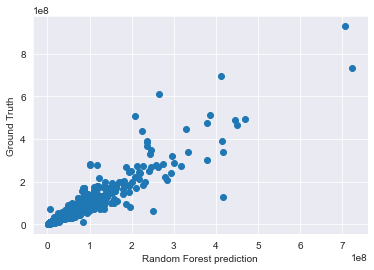

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=42,
)
rf_reg.fit(X_train[f], y_train["price_per_m2"])


rf_train_pred = rf_reg.predict(X_train[f])
rf_val_pred = rf_reg.predict(X_val[f])
rf_val_pred *= X_val.area_total
y_true = y_val["price"]
rf_rsmle = root_mean_squared_log_error(y_true=y_true, y_pred=rf_val_pred)
print(f'Valid rmsle: {rf_rsmle :.4f}')

plt.scatter(rf_val_pred, y_true)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

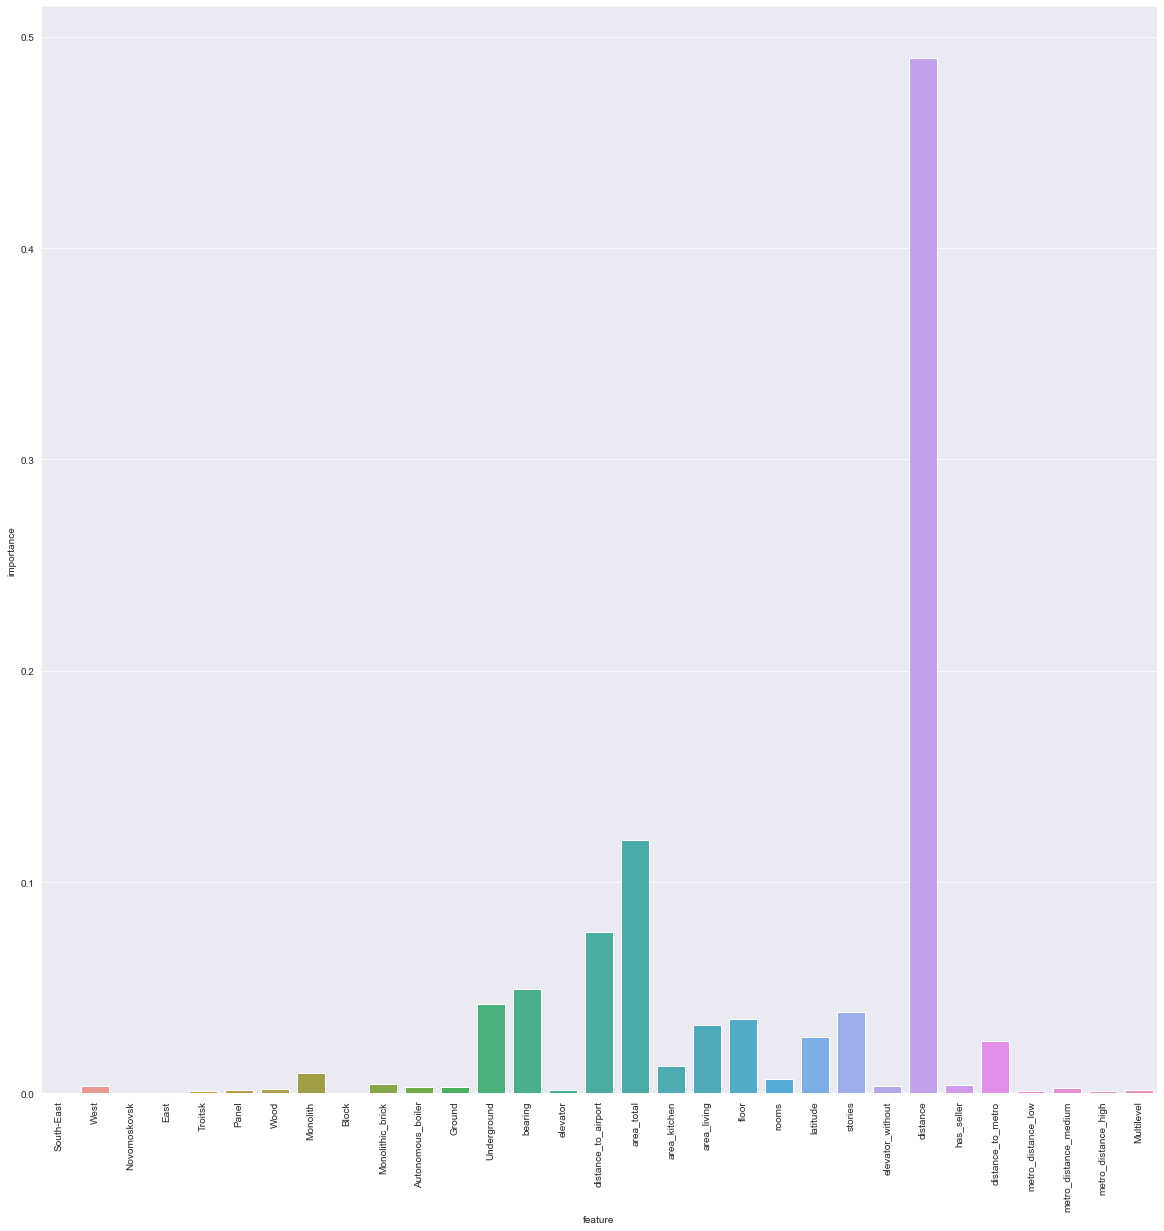

In [65]:
importances = pd.DataFrame({"importance": rf_reg.feature_importances_, "feature": f})
plt.figure(figsize=(20, 20))
ax = sns.barplot(data=importances, x="feature", y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [116]:
f = features.copy()

Valid rmsle: 0.1398


Text(0, 0.5, 'Ground Truth')

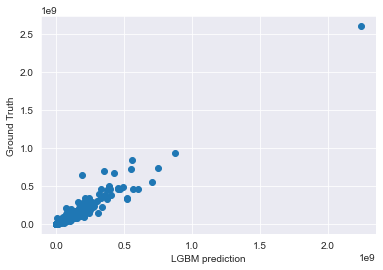

In [117]:
import lightgbm as lgbm

lgbm_reg = lgbm.LGBMRegressor(
    random_state=42,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=35
)

lgbm_reg.fit(X_train[f], y_train["log_price"])

lgbm_pred = lgbm_reg.predict(X_val[f])
lgbm_pred = (np.e ** lgbm_pred) - 1
y_true = y_val["price"]
lgbm_rsmle = root_mean_squared_log_error(y_true=y_true, y_pred=lgbm_pred)
print(f'Valid rmsle: {lgbm_rsmle :.4f}')

plt.scatter(lgbm_pred, y_true)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

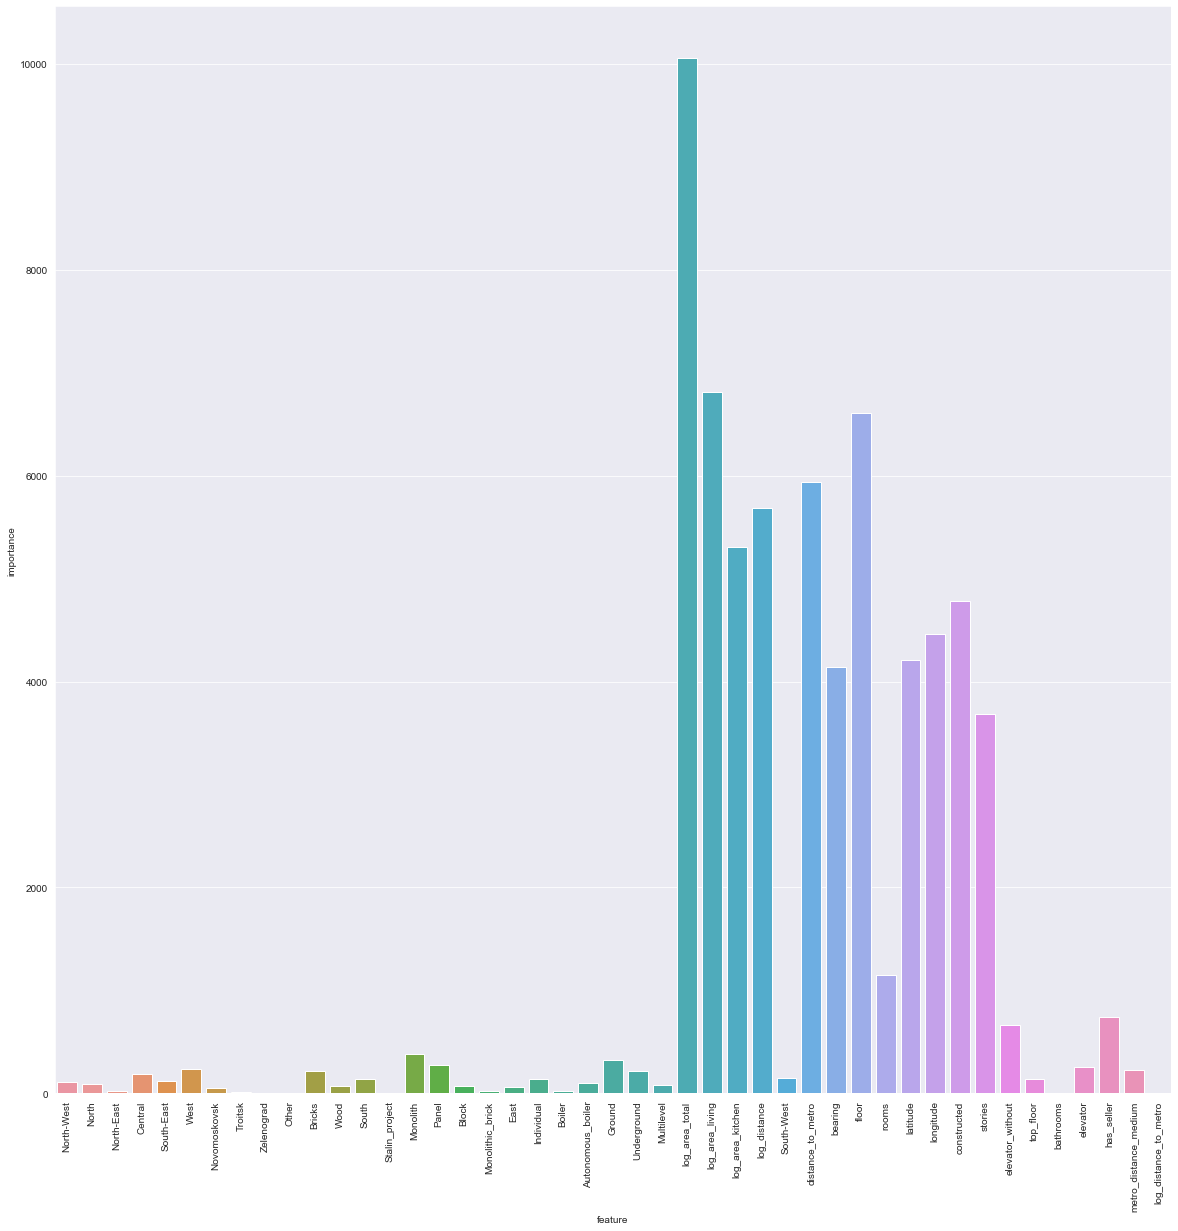

In [108]:
importances = pd.DataFrame({"importance": lgbm_reg.feature_importances_, "feature": f})
plt.figure(figsize=(20, 20))
ax = sns.barplot(data=importances, x="feature", y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [69]:
f = features.copy()
# f = f.drop(
#     [
#         "Panel",
#         "Monolithic_brick",
#         "Block",
#         "East",
#         "Novomoskovsk",
#         "Troitsk",
#         #"log_area_kitchen",
#         "Autonomous_boiler",
#     ]
# )

In [70]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
)

cb.fit(X_train[f], y_train["log_price"])
cb_pred = cb.predict(X_val[f])
cb_pred = (np.e ** cb_pred) - 1
y_true = y_val["price"]
cb_rsmle = root_mean_squared_log_error(y_true=y_true, y_pred=cb_pred)
print(f'Valid rmsle: {cb_rsmle :.4f}')

Valid rmsle: 0.1377


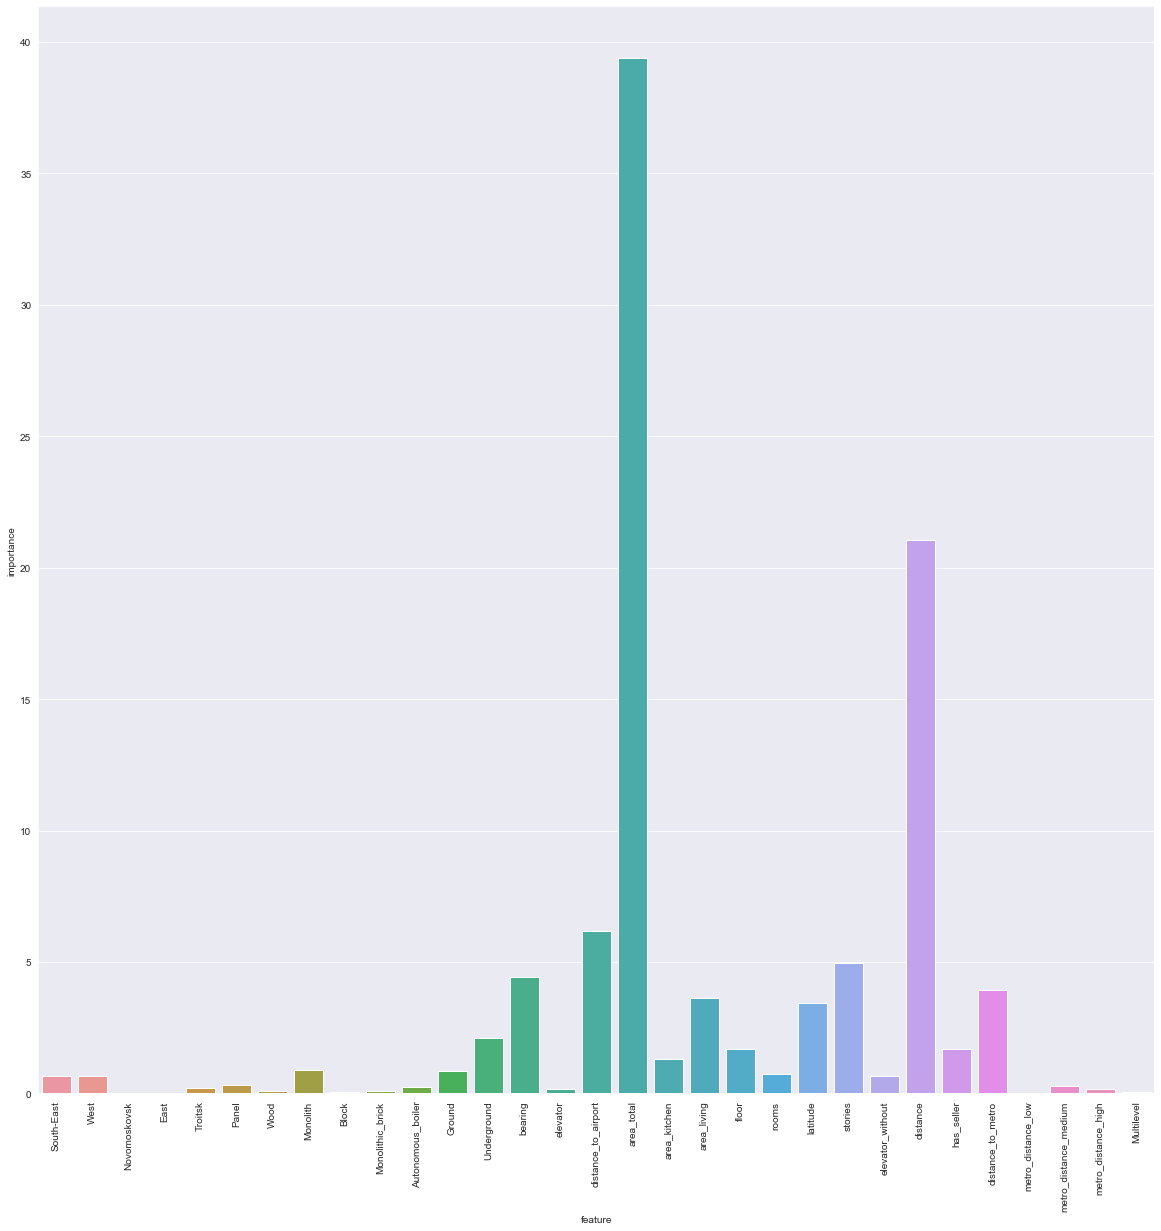

In [71]:
importances = pd.DataFrame({"importance": cb.feature_importances_, "feature": f})
plt.figure(figsize=(20, 20))
ax = sns.barplot(data=importances, x="feature", y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [72]:
f = features.copy()

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    criterion='friedman_mse',
    subsample=0.9,
    max_depth=10
)

gbm.fit(X_train[f], y_train["log_price"])
gbm_pred = gbm.predict(X_val[f])
gbm_pred = (np.e ** gbm_pred) - 1
y_true = y_val["price"]
gbm_rsmle = root_mean_squared_log_error(y_true=y_true, y_pred=gbm_pred)
print(f'Valid rmsle: {gbm_rsmle :.4f}')

Valid rmsle: 0.1564


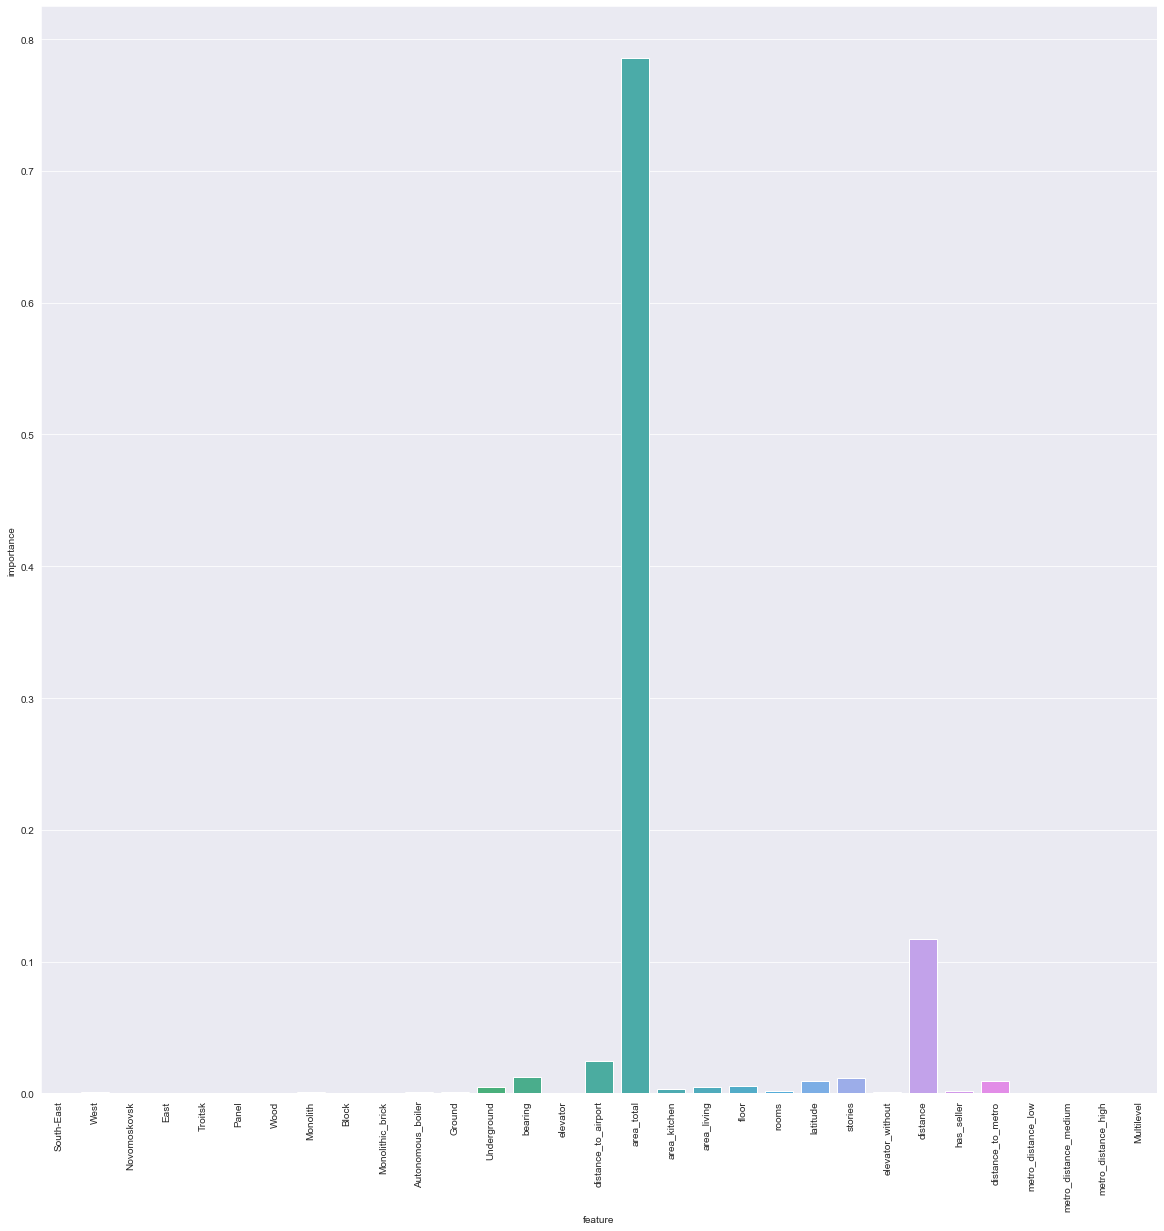

array([0.01257021, 0.02445681, 0.78568383, 0.01167781, 0.11688328])

In [74]:
importances = pd.DataFrame({"importance": gbm.feature_importances_, "feature": f})
plt.figure(figsize=(20, 20))
ax = sns.barplot(data=importances, x="feature", y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()
r = gbm.feature_importances_[gbm.feature_importances_ > 0.01]
r

## Averaging

In [75]:
acc = pd.DataFrame({
    "rf": rf_rsmle,
    "lgbm": lgbm_rsmle,
    "cb": cb_rsmle,
    "gbm": gbm_rsmle,
}, index=[0])
acc = acc.T
acc.columns = ["rsmle"]
acc

,rsmle
rf,0.141150
lgbm,0.139168
cb,0.137658
gbm,0.156397


Valid rmsle: 0.1355


Text(0, 0.5, 'Ground Truth')

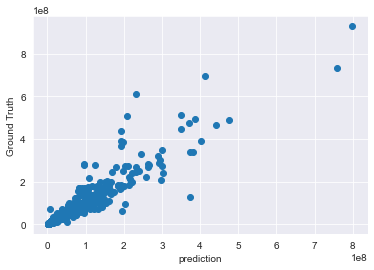

In [76]:
avg_prediction = np.average([rf_val_pred, lgbm_pred, cb_pred, gbm_pred], 
    weights = 1 / acc['rsmle'] ** 4,
    axis=0
)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val["price"], y_pred=avg_prediction) :.4f}')
plt.scatter(avg_prediction, y_val["price"])
plt.xlabel('prediction')
plt.ylabel('Ground Truth')

## K-Fold

# Prediction

In [87]:
data_test = test_imputed
for feat in f:  
    print("#nan in {}: {}".format(feat, len(data_test[data_test[feat].isna()])))

#nan in South-East: 0
#nan in West: 0
#nan in Novomoskovsk: 0
#nan in East: 0
#nan in Troitsk: 0
#nan in Panel: 0
#nan in Wood: 0
#nan in Monolith: 0
#nan in Block: 0
#nan in Monolithic_brick: 0
#nan in Autonomous_boiler: 0
#nan in Ground: 0
#nan in Underground: 0
#nan in bearing: 0
#nan in area_total: 0
#nan in area_kitchen: 0
#nan in area_living: 0
#nan in floor: 0
#nan in rooms: 0
#nan in latitude: 0
#nan in stories: 0
#nan in metro_distance_high: 0
#nan in elevator_without: 0
#nan in distance: 0
#nan in elevator: 0
#nan in has_seller: 0
#nan in distance_to_metro: 0
#nan in metro_distance_low: 0
#nan in metro_distance_medium: 0
#nan in Multilevel: 0


In [88]:
X_test = data_test[f]

In [702]:

rf_pred = rf_reg.predict(X_test)
rf_pred *= X_test.area_total
lgbm_pred = lgbm_reg.predict(X_test)
lgbm_pred = (np.e ** lgbm_pred) - 1
cb_pred = cb.predict(X_test)
cb_pred = (np.e ** cb_pred) - 1
gbm_pred = gbm.predict(X_test)
gbm_pred = (np.e ** gbm_pred) - 1
pred = np.average([rf_pred, lgbm_pred, cb_pred, gbm_pred], 
    weights = 1 / acc['rsmle'] ** 4,
    axis=0
)
# pred = np.mean([rf_pred, lgbm_pred, cb_pred], axis=0)

In [90]:
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = pred
submission.to_csv('submission.csv', index=False)

print('\nLine count of submission')
!wc -l submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 submission.csv


Line count of submission
    9938 submission.csv

First 5 rows of submission
id,price_prediction
23285,28276135.70358786
23286,8560147.178681832
23287,6115550.085664355
23288,10455921.079968458


In [ ]:
###################################
############## END ################
###################################

## Stacking

In [79]:
from sklearn.model_selection import KFold
SEED = 42 # for reproducibility

f = features.copy()

X = data_train[f]
y = data_train['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

ntrain = X_train.shape[0]
ntest = X_val.shape[0]
NFOLDS = 8 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.ravel()

In [80]:
def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [81]:
def ensemble_predict(models, meta_model, X):
    meta_prediction = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_prediction[:, i] = model.predict(X)
    return meta_model.predict(meta_prediction)

In [82]:
model1 = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=SEED,
)

model2 = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=35
)

model3 = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.2,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=SEED,
    bagging_temperature=0.2
)

model4 = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    criterion='friedman_mse',
    subsample=0.9,
    max_depth=10
)

In [83]:
rf_oof_train, rf_oof_val = get_oof(model1, X_train, y_train, X_val)
lgbm_oof_train, lgbm_oof_val = get_oof(model2, X_train, y_train, X_val)
cb_oof_train, cb_oof_val = get_oof(model3, X_train, y_train, X_val)
gbm_oof_train, gbm_oof_val = get_oof(model4, X_train, y_train, X_val)

In [84]:
x_train = np.concatenate((
    rf_oof_train,
    lgbm_oof_train,
    cb_oof_train,
    gbm_oof_train
), axis=1)

x_val = np.concatenate((
    rf_oof_val,
    lgbm_oof_val,
    cb_oof_val,
    gbm_oof_val
), axis=1)

In [85]:
META_MODEL = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.05,
    n_estimators=200,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=30
)

# fit with estimations of training data and decrease the error in predicting the true data
META_MODEL.fit(x_train, y_train)
# predict the test data based on the output of the other models
pred = META_MODEL.predict(x_val)

rsmle = root_mean_squared_log_error(y_true=(np.e ** y_val) - 1, y_pred=(np.e ** pred) - 1)
print(f'Valid rmsle: {rsmle :.4f}')

Valid rmsle: 0.1234


In [89]:
pred = ensemble_predict([model1, model2, model3, model4], META_MODEL, X_test)
pred = (np.e ** pred) - 1